# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_first_time_contributors"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
print(f'{len(df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

df[independent_fields].describe()


Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommente

,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator),...,ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality)
count,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,...,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000,428575.000000
mean,0.265377,0.023897,0.024889,0.491559,0.106380,0.199122,0.005975,0.007852,0.001683,0.009078,...,0.004239,0.018711,0.060183,0.098380,0.002771,0.004929,0.004182,0.007885,0.041572,0.031857
std,0.409443,0.149461,0.150769,0.223152,0.060822,0.165461,0.033704,0.048943,0.022447,0.054829,...,0.036156,0.068647,0.104319,0.153476,0.025471,0.040207,0.033559,0.054341,0.075825,0.067497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.334606,0.075257,0.082942,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.503038,0.075257,0.165884,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.000000,0.000000,0.662179,0.119279,0.306921,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.089382,0.155067,0.000000,0.000000,0.000000,0.000000,0.053459,0.031894
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.989955,0.755371,0.974797,0.893065,0.924125,...,0.874828,0.874470,1.000000,1.000000,0.759557,1.000000,1.000000,0.999543,0.905874,0.880496


## Log-odds linearity


### Visual checking


untransformed
EcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.0
0.10    0.0
0.25    0.5
0.40    0.8
0.50    0.9
0.60    1.0
0.75    1.0
0.90    1.0
1.00    1.0
Name: EcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.0, 0.6666666666666666, 0.85, 1.0, 1.0, 1.0, 1.0], y=[0.3987007080196221, 0.47637373705997843, 0.8896662776268672, 1.2744504731724353, 1.1701382722870333, 1.0842051046051133, 1.0842051046051133, 1.0842051046051133]
DependencyEcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.000000
0.25    0.833333
0.40    1.000000
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: DependencyEcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], y=[0.37073939673433465, 0.8795365395732254, 1.9597304631980157, 1.9236447709459088, 1.9236447709459088, 1.9236447709459088, 1.9236447709459088, 1.9236447709459088]
Inver

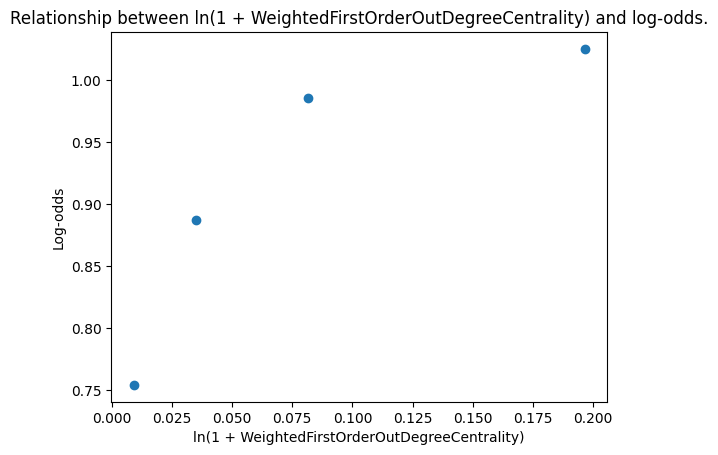

In [3]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame,
    dependent: pd.Series,
    transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include='number')

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r'.*SuccessRate.*', field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[:-len('SuccessRate')]
            count_field = f'ln(1 + {stripped_field}SubmissionCount)'
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f'{field}:')
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[(
                included[field] >= r_start) & (included[field] <= r_end)]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f'Skipped {field} because of division by zero.')
            continue

        print(f'{x=}, {y=}')

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = f'{figure_base_path}/log-odds-independence/{transform_title}/{field}'
        safe_save_fig(output_path)


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include='number')
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field]\
                .apply(transform)
            mn = transformed_independents[field].min()
            mx = transformed_independents[field].max()
            transformed_independents[field] = transformed_independents[field]\
                .apply(lambda x: (x - mn) / (mx - mn))
        test_log_linearity(transformed_independents,
                           dependent, f'{figure_subfolder}/{transform.__name__}')


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value ** 2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value ** 3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, "dependency_model")


## Box-Tidwill Test

In [4]:
import statsmodels.api as sm


def box_tidwill_test(
    independents: pd.DataFrame(),
    dependent: pd.Series()
):
    continuous_fields = independents.select_dtypes(include='number')

    ln_field = f'ln(x) * x'
    for field in continuous_fields:
        test_independents = independents[[field]].copy()
        # TODO: Can you do this?! the ``1 + x`` thing?
        test_independents[ln_field] = test_independents[field]\
            .apply(lambda x: np.log(0.0001 + x) * (0.0001 + + x))
        test_independents = sm.add_constant(test_independents)

        logit_model = sm.Logit(dependent,
                               test_independents).fit()

        p_value = logit_model.pvalues[ln_field]
        is_significant = p_value < 0.05

        test_result = "failed" if is_significant else "passed"
        print(f'{field} {test_result} with {p_value=:.05f}.')


independents: pd.DataFrame = df[independent_fields]
dependent: pd.Series = df[pr_merged_key]
box_tidwill_test(independents, dependent)


Optimization terminated successfully.
         Current function value: 0.633591
         Iterations 5
EcosystemExperienceSubmitterPullRequestSuccessRate failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.639030
         Iterations 6
DependencyEcosystemExperienceSubmitterPullRequestSuccessRate passed with p_value=0.62805.
Optimization terminated successfully.
         Current function value: 0.639377
         Iterations 6
InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate failed with p_value=0.00005.
Optimization terminated successfully.
         Current function value: 0.588677
         Iterations 5
ln(1 + ControlPullRequestLifeTimeInMinutes) failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.638680
         Iterations 6
ln(1 + ControlNumberOfCommitsInPullRequest) failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.636

## Multicollinearity


In [5]:
value_counts = df[ftc_key].value_counts()
print(value_counts)

SubmitterIsFirstTimeContributor
True    428575
Name: count, dtype: int64


In [6]:
# Original multicollinear field list.
# multicollinear_fields = [
#     # Ignored field.
#     "SubmitterIsFirstTimeContributor",
#     # Is zero for each field.
#     "ControlIntegratedBySameUser",

#     # ### Cluster: shared experience.
#     # "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)",
#     # "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)",
#     "ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)",

#     # ### Cluster: Intra + Shared experience.
#     # "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
#     "ln(1 + IntraProjectSubmitterIssueCommentCount)",
#     "ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)",
#     # "ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)",

#     # ### Cluster: inversed dep
#     "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
#     # "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
#     "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
#     "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
#     "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",

#     # ### Cluster: dependency experience.
#     "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
#     # "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
#     "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
#     # "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
#     "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)",

#     # ### Cluster: ecosystem exp + centrality (which in this context is essentially the same).
#     "EcosystemExperienceSubmitterPullRequestSuccessRate",
#     # "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
#     "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
#     "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
#     "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",
#     "ln(1 + WeightedFirstOrderInDegreeCentrality)",
#     "ln(1 + WeightedFirstOrderOutDegreeCentrality)"
# ]


# Standardized list of multicollinear fields.
multicollinear_fields = [
    # non-predictor
    "SubmitterIsFirstTimeContributor",

    # n/a field
    "ControlIntegratedBySameUser",
    
    # dep
    "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)",

    # Inv. dep
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",

    # Shared experience.
    "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)",
    "ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)",
    # "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)",

    # intra-proj
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",

    # ecosystem
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",

    # fo-degree
    "ln(1 + WeightedFirstOrderOutDegreeCentrality)",
    "ln(1 + WeightedFirstOrderInDegreeCentrality)"
]

print(f'Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity.')


Removing 23 / 36 fields to account for multicollinearity.


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}

    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df


tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


                                             variable       VIF
0                       ControlPullRequestHasComments  4.272497
1                      ControlHasHashTagInDescription  1.471104
2          ControlPullRequestHasCommentByExternalUser  1.568201
3         ln(1 + ControlPullRequestLifeTimeInMinutes)  4.595954
4         ln(1 + ControlNumberOfCommitsInPullRequest)  3.305422
5   ln(1 + ControlIntraProjectPullRequestExperienc...  2.257828
6   ln(1 + SharedExperiencePullRequestSubmittedByS...  1.425755
7   ln(1 + SharedExperiencePullRequestSubmittedByI...  1.216023
8   ln(1 + EcosystemExperienceSubmitterPullRequest...  1.662433
9   ln(1 + DependencyEcosystemExperienceSubmitterP...  1.231173
10  ln(1 + InversedDependencyEcosystemExperienceSu...  1.249853
11  ln(1 + IntraProjectSubmitterIssueSubmissionCount)  1.129585
12  ln(1 + SharedExperienceIssueSubmittedByIntegra...  1.294078


In [8]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:")
print(problematic_vif)


Problematic VIF fields: 0.
Problematic VIF scores:
Empty DataFrame
Columns: [variable, VIF]
Index: []


coof_threshold=0.5
Correlating pairs:
[]

Variable correlation frequency:
[]

Transitive closure of correlating pairs:
[
    []
]


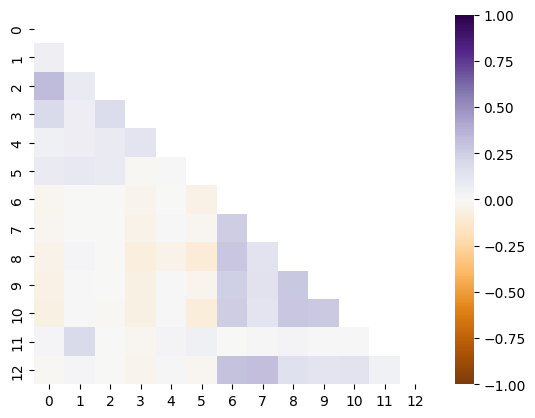

In [9]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr(method='spearman')

rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.


In [10]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = []
    for source, target, coof in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_colors.append('red' if coof < 0 else 'green')

    # Create an empty graph
    graph = nx.Graph()

    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)

    pos = nx.spring_layout(graph, k=0.4)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)
    
    output_path = f'{figure_base_path}/correlating_fields.png'
    safe_save_fig(output_path)

    print(json.dumps(enumerated_list))


In [11]:
print(f'{len(tested_predictors.columns)=}')
print(f'{tested_predictors.columns=}')


len(tested_predictors.columns)=13
tested_predictors.columns=Index(['ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)',
       'ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)'],
      dtype='object')


## Outliers

Using cook's distance.


In [12]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(tested_predictors)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(df[pr_merged_key], X_constant,
                       family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(tested_predictors)

# Append absolute standardized residual values
diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(
    lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)


/tmp/ipykernel_778/2490181039.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_778/2490181039.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(


,cooks_d,std_resid
194367,0.002723,5.350635
98394,0.002636,5.997796
107907,0.002581,13.939638
353006,0.002546,5.189005
123222,0.002403,3.123333
148255,0.002377,11.080576
321251,0.002115,8.653994
150279,0.002110,15.750199
275538,0.001993,12.608173
384807,0.001863,12.635387


9.33356044997095e-06
Found outliers: 913 / 428575 (0.213%)


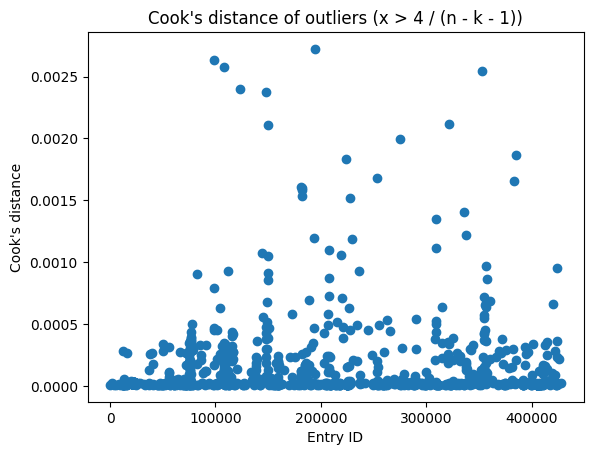

In [13]:
cook_threshold = 4 / (len(tested_predictors) -
                      len(tested_predictors.columns) - 1)
print(cook_threshold)
print(
    f'Found outliers: {len(extreme)} / {len(tested_predictors)} ({100 * len(extreme)/len(tested_predictors):.03f}%)')

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme['cooks_d'])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f'{figure_base_path}/cooks_outliers.png'
safe_save_fig(output_path)


Removes outliers

In [14]:
tested_predictors = tested_predictors.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f'{len(tested_predictors)=}')

len(tested_predictors)=427662


# Model Creation

Creates a simple mixed effect logistic regression model.

In [15]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[tested_predictors.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    tested_predictors,
    tested_projects,
).fit()

mixed_model.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Mixed Linear Model Regression Results
============================================================================================================================
Model:                                 MixedLM                    Dependent Variable:                    PullRequestIsMerged
No. Observations:                      427662                     Method:                                REML               
No. Groups:                            20043                      Scale:                                 0.1661             
Min. group size:                       1                          Log-Likelihood:                        -257899.1603       
Max. group size:                       510                        Converged:                             Yes                
Mean group size:                       21.3                                                                                 
----------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------------
ControlPullRequestHasComments                                                    -0.067    0.002 -38.005 0.000 -0.070 -0.063
ControlHasHashTagInDescription                                                    0.038    0.002  24.983 0.000  0.035  0.041
ControlPullRequestHasCommentByExternalUser                                       -0.025    0.002 -14.144 0.000 -0.028 -0.021
ln(1 + ControlPullRequestLifeTimeInMinutes)                                      -0.196    0.003 -60.456 0.000 -0.202 -0.190
ln(1 + ControlNumberOfCommitsInPullRequest)                                      -0.057    0.011  -5.152 0.000 -0.079 -0.035
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)                      1.413    0.006 219.042 0.000  1.400  1.426
ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)     0.353    0.017  21.220 0.000  0.321  0.386
ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)     0.062    0.034   1.825 0.068 -0.005  0.128
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)                    0.315    0.005  61.416 0.000  0.305  0.325
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)          0.081    0.019   4.162 0.000  0.043  0.119
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)  0.048    0.017   2.818 0.005  0.015  0.082
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                                 0.121    0.017   7.151 0.000  0.088  0.155
ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)          0.163    0.021   7.864 0.000  0.123  0.204
Group Var                                                                         0.524    0.016                            
============================================================================================================================

"""

In [16]:
import os

# outputs results to a csv.

summ = mixed_model.summary()
print(summ)

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f'First-time Contributor Model: {field}'] = fields[field]

dir_name = f'{base_path}/coefs/{file_name}/'
output_path = f'{dir_name}/coefs.csv'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
output.to_csv(output_path)


                                           Mixed Linear Model Regression Results
Model:                                 MixedLM                    Dependent Variable:                    PullRequestIsMerged
No. Observations:                      427662                     Method:                                REML               
No. Groups:                            20043                      Scale:                                 0.1661             
Min. group size:                       1                          Log-Likelihood:                        -257899.1603       
Max. group size:                       510                        Converged:                             Yes                
Mean group size:                       21.3                                                                                 
----------------------------------------------------------------------------------------------------------------------------
                                            